In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

# MDN

In [3]:
coord_path = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\coordinates_mdn_224")

In [4]:
summ_df = pd.read_csv(r"C:\Users\inserm\Documents\histo_sign\dataset\mdn_summary_vst.csv")

In [5]:
summ_df

,patient_ID,sample_ID,ID_Nucleic_Acid,ID_scan,histological_aspect,sous_type_visuel,stroma_visual_aspect,path_svs,path_xml,IMMU_Tcellatlas_CD4.CD8_c4_Tstr,...,PDAC_CSY20_Sig9,PDAC_CSY20_Sig12,Exocrine,Endocrine,Classic,StromaActiv,Basal,StromaActivInflam,Immune,StromaInactive
0,BPDAC_001,BPDAC_001_18_L1,BPDAC_001_18_L1_S21,543933-18_MDNF01_HES,gland_forming,classic,active,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.004568,...,-0.275023,-0.244319,1.304345,1.178035,0.883493,-0.590547,-0.083541,-0.854921,-0.218141,-0.143778
1,BPDAC_001,BPDAC_001_23_L1,BPDAC_001_23_L1_S22,543933-23_MDNF01_HES,gland_forming,classic,inactive,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.007808,...,-0.297615,-0.221408,0.913259,0.283827,-0.966686,0.759270,0.086692,-0.729972,0.357768,0.537943
2,BPDAC_001,BPDAC_001_24_L1,BPDAC_001_24_L1_S23,543933-24_MDNF01_HES,gland_forming,classic,inactive,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.310778,...,-0.280250,-0.242592,-0.022753,1.278563,1.203993,-1.048311,-0.265034,-0.696960,-0.838408,-1.100028
3,BPDAC_001,BPDAC_001_24_L2,BPDAC_001_24_L2_S24,543933-24_MDNF01_HES,non_gland_forming,basal,inactive,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,3.938735,...,14.820437,14.846703,0.398008,-0.444039,-1.224412,-1.897608,-1.783677,-1.201639,-1.238123,1.192559
4,BPDAC_002,BPDAC_002_14_L1,BPDAC_002_14_L1_S26,544085-14_MDNF01_HES,gland_forming,classic,active,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,0.001919,...,-0.063539,-0.200254,8.598637,0.851158,-0.222870,-1.179959,-3.077233,-0.124558,-2.357668,0.056799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,BPDAC_100,BPDAC_100_23_L1,X0423_016,14AG03361-23_MDNF01_HES,NaN,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.335175,...,0.020023,0.024474,-0.189934,0.395346,-1.105983,-2.354096,0.217331,-1.428591,0.311990,-1.100432
401,BPDAC_101,BPDAC_101_16_L1,X0423_020,14AG03394-16_MDNF01_HES,non_gland_forming,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,0.031301,...,-0.289671,-0.221549,-0.813832,-0.680728,-2.398914,0.483809,1.867730,0.893317,-0.745579,-1.865732
402,BPDAC_101,BPDAC_101_21_L1,X0423_021,14AG03394-21_MDNF01_HES,non_gland_forming,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.319148,...,-0.277551,-0.091988,-0.119870,-0.495132,-1.292487,1.265700,1.083280,0.048836,-0.430123,-0.115555
403,BPDAC_101,BPDAC_101_21_L2,X0423_022,14AG03394-21_MDNF01_HES,non_gland_forming,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.312502,...,-0.223764,-0.233952,-0.878966,-0.461685,-2.463755,0.716643,1.948524,0.711195,-1.028648,-1.442472


## Number of tiles

In [6]:
def get_n_tiles(sample_id):
    n_tiles = np.load(coord_path / sample_id / "tiles_coord.npy").shape[0]
    return n_tiles


summ_df["n_tiles"] = summ_df.sample_ID.apply(get_n_tiles)

In [7]:
print(f"Total number of tiles: {summ_df['n_tiles'].sum()}")

Total number of tiles: 79982


In [8]:
summ_df.groupby(by="patient_ID").n_tiles.mean()

patient_ID
BPDAC_001    275.000000
BPDAC_002    200.166667
BPDAC_003    324.750000
BPDAC_004    286.666667
BPDAC_005    288.333333
                ...    
BPDAC_097    152.000000
BPDAC_098    196.666667
BPDAC_099    135.333333
BPDAC_100     93.666667
BPDAC_101     78.250000
Name: n_tiles, Length: 95, dtype: float64

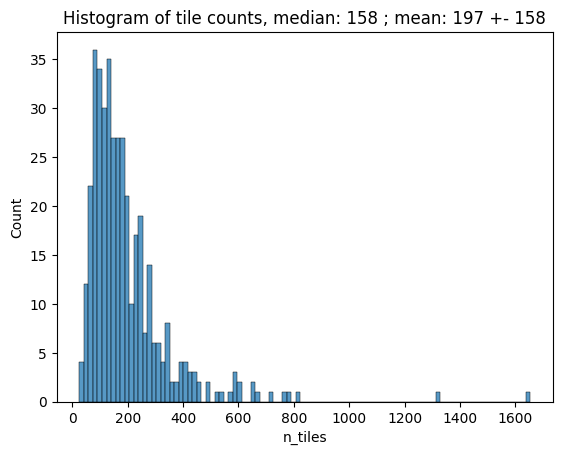

In [9]:
sns.histplot(summ_df["n_tiles"], bins=100)
plt.title(
    "Histogram of tile counts, median: {:.0f} ; mean: {:.0f} +- {:.0f}".format(
        np.median(summ_df["n_tiles"]), np.mean(summ_df["n_tiles"]), np.std(summ_df["n_tiles"])
    )
)
plt.show()

In [10]:
print(
    f" {summ_df.shape[0]} rows, {summ_df.sample_ID.nunique()} samples, {summ_df.patient_ID.nunique()} patients, {summ_df.ID_scan.nunique()} scans"
)

 405 rows, 405 samples, 95 patients, 238 scans


## Explore labels

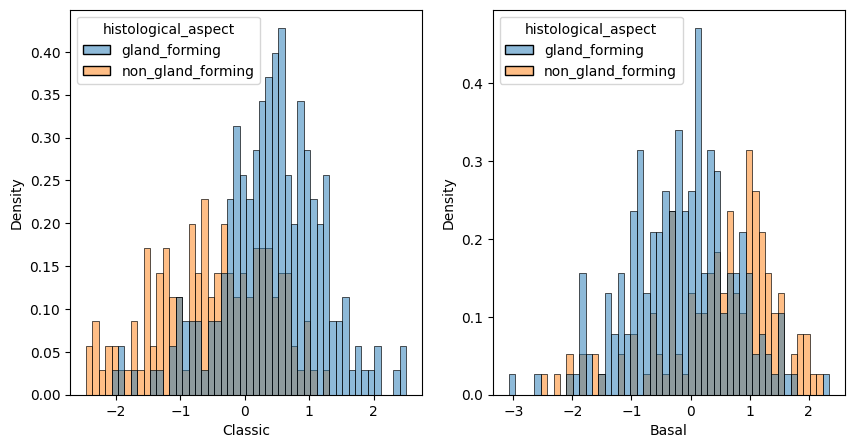

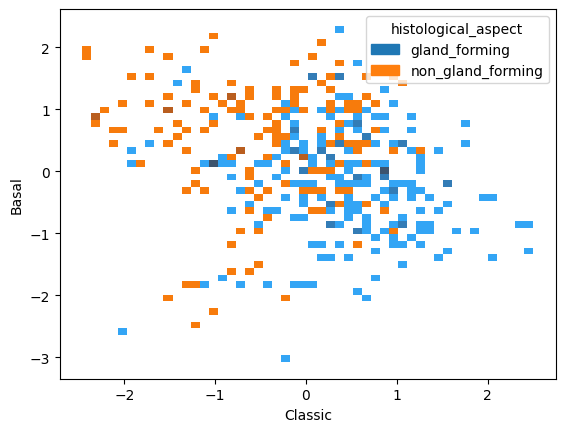

In [11]:
labels = summ_df[["Basal", "Classic", "histological_aspect"]]
labels = labels[labels["histological_aspect"].isin(["gland_forming", "non_gland_forming"])]
# labels[labels.isna().any(axis=1)]
labels = labels.dropna()
# Compute correlation between histological aspect and molecular subtypes
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# labels["histological_aspect"] = le.fit_transform(labels["histological_aspect"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(labels, x="Classic", hue="histological_aspect", bins=50, ax=ax1, stat="density")
sns.histplot(labels, x="Basal", hue="histological_aspect", bins=50, ax=ax2, stat="density")
plt.show()

# Bivariate histogram
sns.histplot(labels, x="Classic", y="Basal", bins=50, hue="histological_aspect")
plt.show()

<Axes: xlabel='Classic', ylabel='Basal'>

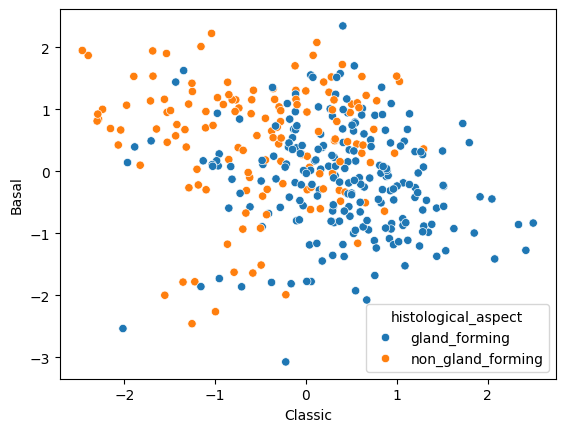

In [12]:
sns.scatterplot(data=labels, x="Classic", y="Basal", hue="histological_aspect")

# Correlation between signatures

In [15]:
summ_df

,patient_ID,sample_ID,ID_Nucleic_Acid,ID_scan,histological_aspect,sous_type_visuel,stroma_visual_aspect,path_svs,path_xml,IMMU_Tcellatlas_CD4.CD8_c4_Tstr,...,PDAC_CSY20_Sig12,Exocrine,Endocrine,Classic,StromaActiv,Basal,StromaActivInflam,Immune,StromaInactive,n_tiles
0,BPDAC_001,BPDAC_001_18_L1,BPDAC_001_18_L1_S21,543933-18_MDNF01_HES,gland_forming,classic,active,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.004568,...,-0.244319,1.304345,1.178035,0.883493,-0.590547,-0.083541,-0.854921,-0.218141,-0.143778,251
1,BPDAC_001,BPDAC_001_23_L1,BPDAC_001_23_L1_S22,543933-23_MDNF01_HES,gland_forming,classic,inactive,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.007808,...,-0.221408,0.913259,0.283827,-0.966686,0.759270,0.086692,-0.729972,0.357768,0.537943,123
2,BPDAC_001,BPDAC_001_24_L1,BPDAC_001_24_L1_S23,543933-24_MDNF01_HES,gland_forming,classic,inactive,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.310778,...,-0.242592,-0.022753,1.278563,1.203993,-1.048311,-0.265034,-0.696960,-0.838408,-1.100028,497
3,BPDAC_001,BPDAC_001_24_L2,BPDAC_001_24_L2_S24,543933-24_MDNF01_HES,non_gland_forming,basal,inactive,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,3.938735,...,14.846703,0.398008,-0.444039,-1.224412,-1.897608,-1.783677,-1.201639,-1.238123,1.192559,229
4,BPDAC_002,BPDAC_002_14_L1,BPDAC_002_14_L1_S26,544085-14_MDNF01_HES,gland_forming,classic,active,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,0.001919,...,-0.200254,8.598637,0.851158,-0.222870,-1.179959,-3.077233,-0.124558,-2.357668,0.056799,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,BPDAC_100,BPDAC_100_23_L1,X0423_016,14AG03361-23_MDNF01_HES,NaN,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.335175,...,0.024474,-0.189934,0.395346,-1.105983,-2.354096,0.217331,-1.428591,0.311990,-1.100432,94
401,BPDAC_101,BPDAC_101_16_L1,X0423_020,14AG03394-16_MDNF01_HES,non_gland_forming,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,0.031301,...,-0.221549,-0.813832,-0.680728,-2.398914,0.483809,1.867730,0.893317,-0.745579,-1.865732,67
402,BPDAC_101,BPDAC_101_21_L1,X0423_021,14AG03394-21_MDNF01_HES,non_gland_forming,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.319148,...,-0.091988,-0.119870,-0.495132,-1.292487,1.265700,1.083280,0.048836,-0.430123,-0.115555,58
403,BPDAC_101,BPDAC_101_21_L2,X0423_022,14AG03394-21_MDNF01_HES,non_gland_forming,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.312502,...,-0.233952,-0.878966,-0.461685,-2.463755,0.716643,1.948524,0.711195,-1.028648,-1.442472,66


In [13]:
# select only signature columns
signatures = summ_df.columns.values[9:-1]
signatures_df = summ_df[signatures]
sign_corr = signatures_df.corr()

In [14]:
# select max correlation for each signature excluding itself
best_corr = sign_corr.apply(lambda x: x[x != 1].idxmax())
best_corr = pd.DataFrame(best_corr, columns=["best_corr"])
best_corr["value"] = best_corr.apply(lambda x: sign_corr.loc[x.name, x.best_corr], axis=1)
best_corr.sort_values(by="value", ascending=False, inplace=True)
best_corr

,best_corr,value
PDAC_CSY20_Sig5,PDAC_Moffitt15_Endocrine,0.992254
PDAC_Moffitt15_Endocrine,PDAC_CSY20_Sig5,0.992254
CAF_FMG20_Normal.Fibroblast,PDAC_CSY20_Sig5,0.987701
PDAC_Hwang22_Malignstate.CyclingG2M,PDAC_Hwang22_Malignstate.CyclingS,0.985588
PDAC_Hwang22_Malignstate.CyclingS,PDAC_Hwang22_Malignstate.CyclingG2M,0.985588
...,...,...
StromaActivInflam,StromaActiv,0.391490
Endocrine,Classic,0.364963
Classic,Endocrine,0.364963
StromaInactive,StromaActivInflam,0.332259


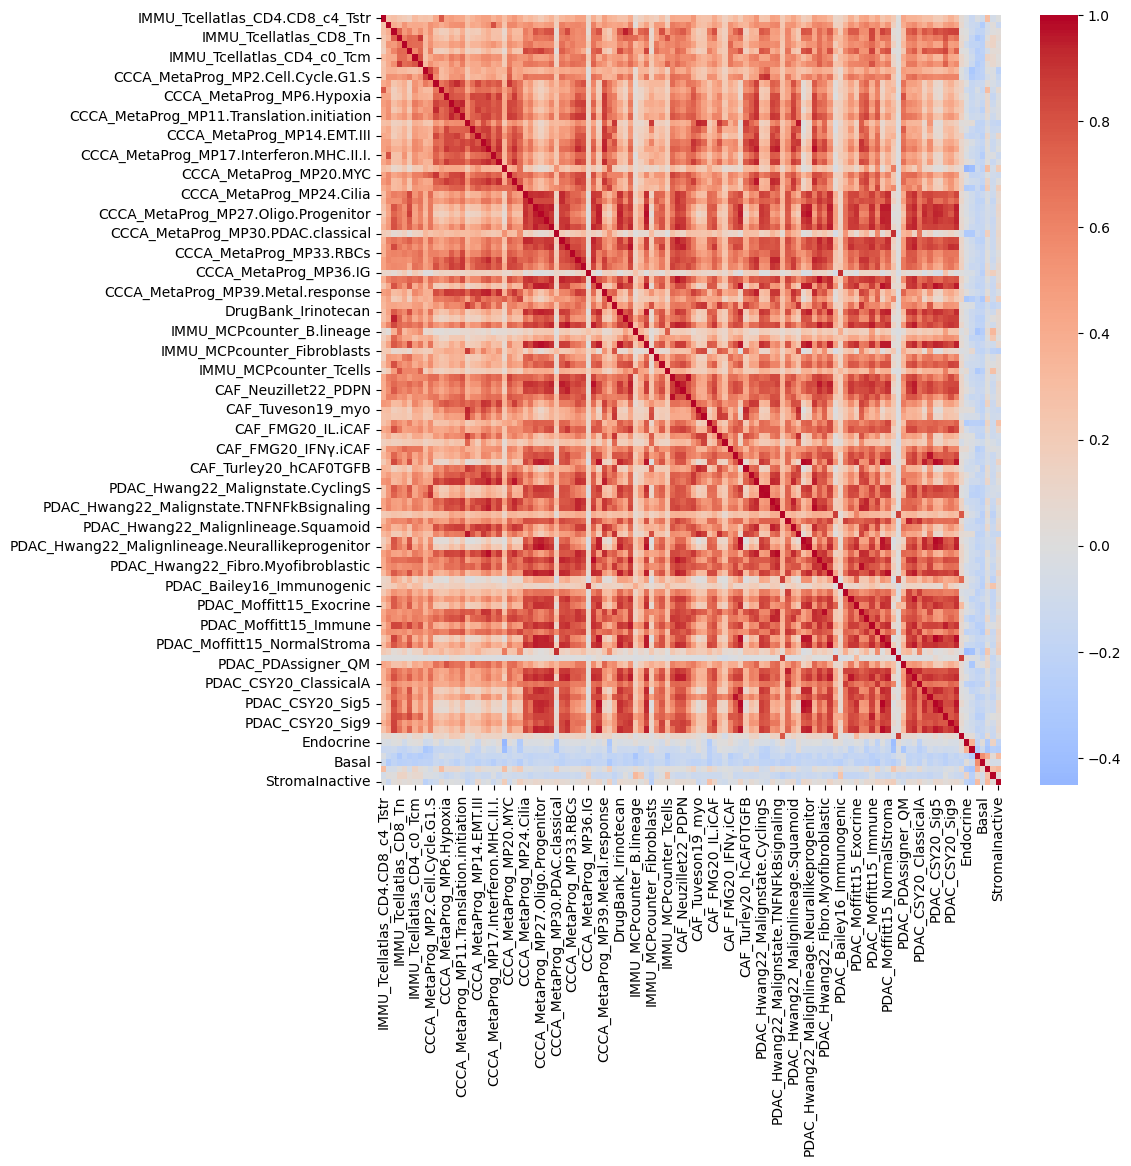

In [31]:
# display correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(sign_corr, annot=False, cmap="coolwarm", center=0)
plt.show()

# PancMulticentric

In [3]:
summ_df = pd.read_csv(r"C:\Users\inserm\Documents\histo_sign\dataset\panc_summary_vst.csv")
path_annot = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\coordinates_panc_224")

In [4]:
row = summ_df.iloc[0]


def get_tiles_info(row):
    sample_ID = row.sample_ID
    try:
        coords = np.load(path_annot / row.sample_ID / "tiles_coord.npy")
        n_tiles = coords.shape[0]
        n_tum_tiles = int(coords[:, -1].sum())
    except FileNotFoundError:
        n_tiles = np.nan
        n_tum_tiles = np.nan
    return {"n_tiles": n_tiles, "n_tum_tiles": n_tum_tiles}


res = summ_df.progress_apply(get_tiles_info, axis=1, result_type="expand")
summ_df = pd.concat([summ_df, res], axis=1)
summ_df["non_tum_tiles"] = summ_df["n_tiles"] - summ_df["n_tum_tiles"]
summ_df["tum_ratio"] = summ_df["n_tum_tiles"] / summ_df["n_tiles"]

  0%|          | 0/732 [00:00<?, ?it/s]

100%|██████████| 732/732 [00:05<00:00, 127.98it/s]


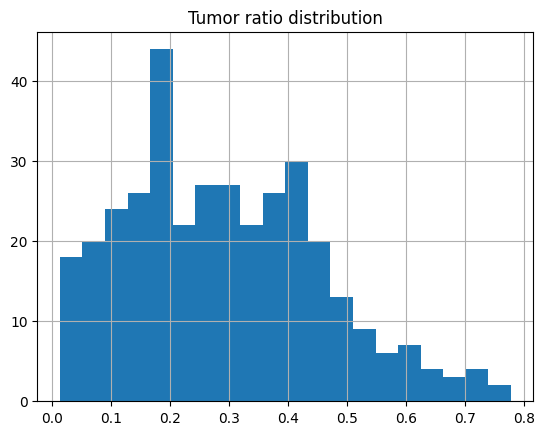

In [5]:
grp = summ_df.groupby(by="patient_ID")
summ_patients = grp.agg(
    {
        "n_tiles": "sum",
        "n_tum_tiles": "sum",
        "non_tum_tiles": "sum",
    }
)
summ_patients["tum_ratio"] = summ_patients["n_tum_tiles"] / summ_patients["n_tiles"]
summ_patients.tum_ratio.hist(bins=20)
plt.title("Tumor ratio distribution")
plt.show()

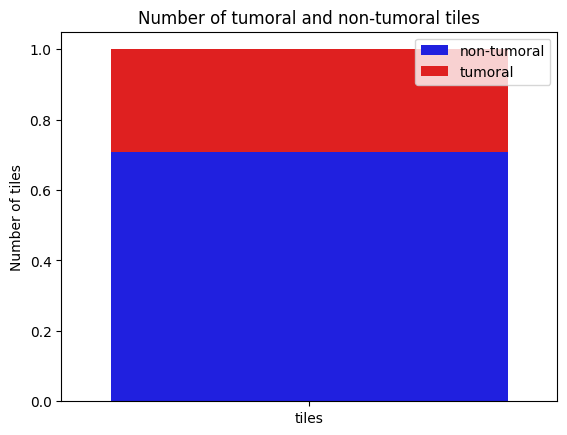

In [6]:
summ_df["non_tum_tiles"] = summ_df["n_tiles"] - summ_df["n_tum_tiles"]
summ_df["tum_ratio"] = summ_df["n_tum_tiles"] / summ_df["n_tiles"]

# # sns stacked barplot
fig, ax = plt.subplots()
sns.barplot(
    x=["tiles"],
    y=summ_df.non_tum_tiles.sum() / summ_df.n_tiles.sum(),
    ax=ax,
    color="blue",
    label="non-tumoral",
)
sns.barplot(
    x=["tiles"],
    y=summ_df.n_tum_tiles.sum() / summ_df.n_tiles.sum(),
    bottom=summ_df.non_tum_tiles.sum() / summ_df.n_tiles.sum(),
    ax=ax,
    color="red",
    label="tumoral",
)
ax.set_ylabel("Number of tiles")
ax.legend()
plt.title("Number of tumoral and non-tumoral tiles")
plt.show()